Contact: {fviola@google.com, rakicevic@google.com}

# Contents
- Setup
 - Download and install packages
 - Imports
- Dataset
 - Import data
 - Helper functions
- Amortized Variational Inference
 - Posterior function modelling
 - Losses
 - Training VAEs using constraint optimization (GECO)
- Practical Excercise
 - Model Implementations
 - Tasks and Conclusions

---
# Set up

Run the following three cells to set up the environment, import basic dependencies and define helper necessary functions.


In [1]:
# @title Download and install packages
! pip install chex -q
! pip install optax -q
! pip install distrax -q
! pip install dm_haiku -q
print("All packages installed!")

     |████████████████████████████████| 76 kB 4.2 MB/s 
     |████████████████████████████████| 145 kB 13.4 MB/s 
     |████████████████████████████████| 272 kB 10.9 MB/s 
     |████████████████████████████████| 342 kB 11.2 MB/s 
All packages installed!


In [2]:
# @title Imports
import time
import functools
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple

import chex
import distrax
import haiku as hk
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


---
# Dataset

In this tutorial we will use a small subset the MNIST dataset. We will load the standard MNIST dataset from which we select a few digits, and small number of sample for each digit, e.g. 3 labels (numbers 0, 6 and 8) and 3 samples for a
total of 9 datapoints. This will make training fast and visualization easy.

In [3]:
# @title Dataset loading and visualisation helper functions
# @markdown We can use TensorFlow data (`tfds`) to download MNIST from the cloud. 
# @markdown <br>[Chex](https://github.com/deepmind/chex) is a library of utilities helping to write more reliable JAX code.
# @markdown Within `chex` you will find a `dataclass` object definition, which will automatically register new class instances into JAX, so you can easily apply JAX's tree utilities out of the box. We will use it to define a labelled data object type.

@functools.lru_cache()
def get_raw_data(data_split='train'):
  """Load and preproces the MNIST dataset."""
  def _preprocess(sample):
    image = tf.cast(sample["image"], tf.float32) / 255.0
    id = sample["label"]
    return image, id
 
  mnist = tfds.load("mnist")

  ds = mnist[data_split]
  ds = ds.map(map_func=_preprocess, 
              num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds = ds.cache()
  ds = ds.shuffle(100000, seed=0).batch(2048)
  images, labels = next(iter(tfds.as_numpy(ds)))

  data_by_label = []
  for i in range(10):
    data_by_label.append(images[labels==i])
  min_num = min([d.shape[0] for d in data_by_label])
  return np.stack([d[:min_num] for d in data_by_label])


@chex.dataclass(frozen=True)
class Dataset:
  image: chex.Array
  label: chex.Array


def get_data_slice(data, labels=(3, 7, 2), num_samples=4):
  """Extract only num_samples of the data for the given labels."""
  labels = np.array(labels)
  data_slice = np.reshape(data[labels, :num_samples], (-1,) + data.shape[-3:])
  batch_size = data_slice.shape[0]
  labels = np.tile(
      np.array(labels).reshape(-1, 1), [1, num_samples]).reshape([batch_size])
  return Dataset(image=data_slice, label=labels)


def gallery(array, ncols=None):
  """Rearrange an array of images into a tiled layout."""
  nindex, height, width, num_channels = array.shape  
  if ncols is None:
    ncols = int(np.sqrt(nindex))    
  nrows = int(np.ceil(nindex/ncols))  
  pad = np.zeros((nrows*ncols-nindex, height, width, num_channels))
  array = np.concatenate([array, pad], axis=0)
  result = (array.reshape(nrows, ncols, height, width, num_channels)
            .swapaxes(1,2)
            .reshape(height*nrows, width*ncols, num_channels))
  return result

def imshow(x, ax=None, title=''):
  """Shorthand for imshow."""
  if ax is None:
    show_image = plt.imshow
    set_axis = plt.axis
    set_title = plt.title
  else:
    show_image = ax.imshow
    set_axis = ax.axis
    set_title = ax.set_title
    
  show_image(x[..., 0], cmap='gist_yarg', interpolation=None)
  set_axis('off')
  set_title(title)


Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


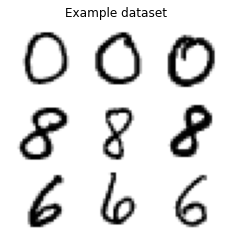

In [4]:
# Load and visualise a sample from the dataset
raw_data = get_raw_data()
data = get_data_slice(raw_data, labels=(0, 8, 6), num_samples=3)
imshow(gallery(data.image), title='Example dataset')

---
# Amortized variational inference (Variational Autoencoders)

Consider a joint distribution $p(x, z)$ over a set of latent variables $z \in \mathcal{Z}$ and observed variable $x \in \mathcal{X}$ (for instance, the images of our dataset).

Making inference over the observed variable $x$ involves computing the posterior distribution $p(z|x) = \frac{p(x,z)}{p(x)}$ which is often intractable to compute, as the _marginal likelihood_ $p(x) = \int_z p(x, z)dz$ requires integrating over a potentially exponential number of configurations of $z$.

**Variational Inference (VI)** can be used to approximate the posterior $p(z|x)$ in a tractable fashion. VI casts the problem of computing the posterior as an optimization problem introducing a family of tractable (simpler) distribution $\mathcal{Q}$ parametrized by $\phi$. The objective is to find the best approximation of the true posterior $q_{\phi^*} \in \mathcal{Q}$ that minimizes the Kullback-Leibler (KL) divergence with the exact prosterior:

$$
q_{\phi^*}(z) = \underset{q_{\phi}}{arg min} \ \ D_{KL}(q_{\phi}(z) || p(z|x))
$$

$q_{\phi^*}(z)$ can serve as a proxy for the true posterior distribution. Note that the solution depends on the speciﬁc value of the observed (evidence) variables $x_i$ we are conditioning on, so computing the posterior requires solving an optimization problem for each sample independently.

In this tutorial, we use a much more efficient approach. Rather than solving an optimization process per data point, we can **amortize the cost of inference** by leveraging the power of function approximation and learn a deterministic mapping to predict the distributional variables as a function of $x$. Specifically, the posterior parameters for $x_i$ will be the output of a *learned* function $f_\theta(x_i)$, where $\theta$ are parameters shared across all data points.


<img src="https://lilianweng.github.io/posts/2018-08-12-vae/autoencoder-architecture.png" alt="VAE" width="800"/>

[Image credit: [lilianweng.github.io](https://lilianweng.github.io/posts/2018-08-12-vae/)]

For more information, see:
* [Kingma and Welling, (2013), Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114),
* [Kingma and Welling, (2019), An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691)
  

## Posterior function modelling

In this exercise we will use two models for the posterior distribution $q_{\phi}$, which we introduce next.

### Gaussian posterior 

The simplest posterior model is a diagonal Gaussian
$q_{\phi}(z|x) = \mathcal{N}(z|\mu_{\theta}(x), diag(\sigma^2_{\theta}(x)))$, where $f_{\theta}$ can be modelled e.g. using a neural network, whose outputs define the parameters  $\phi = \{\mu_{\theta}, \sigma^2_{\theta} \}$ of the distribution.
Sampling from this Gaussian is achieved employing the **reparameterization trick** that disentangles the noise source, so that the gradients can be backpropagated:
$$
z \sim \mathcal{N}(z|\mu, \sigma^2) \Leftrightarrow z = \mu + \sigma\epsilon,  \epsilon \sim \mathcal{N}(0, 1)
$$ 
In the _Practical Exercise_ section you will implement the Gaussian posterior and prior, and train a VAE with this posterior model.

<img src="https://lilianweng.github.io/posts/2018-08-12-vae/vae-gaussian.png" alt="VAE reparameterisation trick" width="800"/>

[Image credit: [lilianweng.github.io](https://lilianweng.github.io/posts/2018-08-12-vae/)]

However, one prominent limitation of this VAEs instance is the the limited expressiveness of diagonal Gaussian posterior approximations and how well it can be trained to match the prior. For example, it has been observed empirically that VAEs with simple posterior models have a tendency to ignore some of the latent-variables (latent-collapse) and produce blurred reconstructions. 
<br>NOTE: We will not observe this in this tutorial, since we will use a simple 2-dimensional latent and very small dataset.


### Flow-based posterior

An ideal family of variational distributions $q_{\phi}(z|x)$ is one that is  flexible enough to contain the true posterior as one solution.
A **normalizing flow** describes the transformation of a probability density through a sequence of invertible mappings.
By repeatedly applying the rule for change of variables, the initial density "flows" through the sequence of invertible mappings. At the end of this sequence we obtain a valid probability distribution and hence this type of flow is referred to as a normalizing flow.

If we use an invertible mapping $f$ to transform a random variable $z$ with distribution $q(z)$, the resulting random variable $z' = f(z)$ has a distribution:

$$
q(z') = q(z) \left | \text{det} \frac{\partial f^{−1}}{\partial z'} \right | = q(z) \left | \text{det} \frac{\partial f}{\partial z} \right |^{−1}
$$

where the last equality can be seen by applying the chain rule (inverse function theorem) and is a property of Jacobians of invertible functions. We can construct arbitrarily
complex densities by composing several simple maps and
successively applying the equation above.

The density $q_K(z)$ obtained by successively transforming a random variable $z_0$ with distribution $q_0$ through a chain of $K$ transformations $f_k$ is:

$$
z_K = f_K \ \circ \ . . . \ \circ \ f_2 \ \circ \ f_1(z_0) \\
\text{ln} \ q_K(z_K) = \text{ln} \ q_0(z_0) − \sum_{k=1}^K \text{ln} \left | \text{det} \frac{\partial f_k}{\partial z_{k-1}} \right |
$$

We can understand the effect of invertible flows as a sequence of expansions or contractions on the initial density. With an appropriate choice of transformations $f_K$, we can initially use simple factorized distributions such as an independent Gaussian, or Uniform, and apply normalizing flows of different lengths to obtain increasingly complex and multi-modal distributions.


<img src="https://lilianweng.github.io/posts/2018-10-13-flow-models/normalizing-flow.png" alt="Normalizing Flow model" width="700"/>

[Image credit: [lilianweng.github.io](https://lilianweng.github.io/posts/2018-10-13-flow-models/)]

For more information, see:
* [Rezende and Mohamed, (2016), Variational Inference with Normalizing Flows](https://arxiv.org/pdf/1505.05770.pdf),

## Losses


We use maximum likelihood for training, that is, ideally we would like to maximize:

$$\mathbb{E}_{x \sim P^*}\log p_{\theta}(x)$$

Note that $p_{\theta}(x)$ is the marginal probability distribution $p_{\theta}(x) = \int p_\theta(x, z) dz$. We can rewrite this in familiar terms as $\int p_\theta(x|z) p(z) dz$. However, computing (and maximizing) the above marginal is computationally infeasible.

Instead, we can show:

$$\log p_{\theta}(x) \ge \mathbb{E}_{z \sim q(z|x)} \big[\log p_\theta(x | z)\big] - \mathbb{KL}\big(q_\phi(z | x) || p(z)\big)$$

This right hand side is called the evidence lower bound (ELBO). Broadly speaking the term variational methods, like variational inference, refers to this technique of using an approximate posterior distribution and the ELBO; this is where Variational Autoencoder gets its name from too.

In order to try to maximize the likelihood, we maximize the lower bound (ELBO) instead, using e.g. Stochastic Gradient Descent. This yields the following loss used with Variational AutoEncoders:

<font size=4>
<!-- $$ \\mathcal{L}(X, z) = \\mathbb{E}\\big[\\log P(X|z)\\big] - D_{KL}\\big[Q(z|X) \\big|\\big| P(z)\\big].$$ -->
$$ 
\mathcal{L}(x) = - \Big( \mathbb{E}_{z \sim q(z|x)} \big [ \log p_\theta(x | z)\big] - \mathbb{KL}\big(q_\phi(z | x) || p(z)\big) \Big)
$$
</font>

<br>

Therefore, training this model is called Stochastic Variational Inference.

Observe that:
* The first term encourages the model to reconstruct the input faithfully. This part is similar to the Vanilla AutoEncoder.
* The second term can be seen as a *regularization term* of the encoder towards the prior.

(The formula contains an expectation; in practice that would be approximated with one or more samples.)

## Balancing the loss terms and constrained optimisation

Stochastic Variational Inference can get stuck in local optima since there is a certain tension between the likelihood and the KL terms. To ease the optimization, we could use a schedule for a balance parameter $\beta$ where the KL coefficient is slowly annealed from  to  throughout training [(Higgins et al, 2016)](https://openreview.net/pdf?id=Sy2fzU9gl). This corresponds to weight more the reconstruction term at the beginning of the training and then move towards the fully stochastic variational objective. The modified objective becomes:

<font size=4>

<!-- $$ \\mathcal{L}(X, z) = \\mathbb{E}\\big[\\log P(X|z)\\big] - D_{KL}\\big[Q(z|X) \\big|\\big| P(z)\\big].$$ -->

$$ 
\mathcal{L}(x) = - \Big( \mathbb{E}_{z \sim q(z|x)} \big [ \log p_\theta(x | z)\big] - \beta \ \mathbb{KL}\big(q_\phi(z | x) || p(z)\big) \Big)
$$
</font>

<br>

However, **constrained optimization** can be used to dynamically tune the relative weight of the likelihood and KL terms during optimization. This removes the need to manually tune , or create an optimization schedule, which can be problem specific.

The objective now becomes:

<font size=4>
$$
  \text{minimize } \mathbb{E}_{p^*(x)} \mathbb{KL}(q(z|x)||p(z)) 
  \\ \text{such that }  \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x) \log p_\theta(x|z)} > \kappa
$$
</font>

<br>

This can be solved using Lagrange multipliers. The objective then becomes:

<font size=4>
$$
\text{minimize }  \mathbb{E}_{p^*(x)} \mathbb{KL} \left ( q(z|x)||p(z) \right ) + \lambda \  \Big(\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\kappa - \log p_\theta(x|z))\Big)
$$
</font>

<br>

The difference compared to the KL annealing is that:

* $\lambda$ is a learned parameter - it will be learned using stochastic gradient descent, like the network parameters.  The difference is that the Lagrangian has to solve a maximization problem. You can see this intuitively: the gradient with respect to $\lambda$ in the objective above is $\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))$. If $ \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))> 0$, the constraint is not being satisfied, so the value of the Lagrangian needs to increase. This will be done by doing gradient ascent, instead of gradient descent. Note that for $\lambda$ to be a valid Lagrangian in a minimization problem, it has to be positive ($\lambda$ > 0).

* The practicioner has to specify the hyperparameter $\kappa$, which determines the reconstruction quality of the model.

* The $\kappa$ coefficient is in front of the likelihood term, not the KL term. This is mainly for convenience, as it is often easier to specify the hyperparameter $\kappa$ for the likelihood (e.g. domain specific reconstruction loss).

<br>

For more assumptions made by this method, see the [Karush–Kuhn–Tucker conditions](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions).

For more information, see:
* [Higgins et al, (2016), beta-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework](https://openreview.net/pdf?id=Sy2fzU9gl)
* [Rezende and Viola, (2018), Taming VAEs](https://arxiv.org/abs/1810.00597v1?)
* [Rezende and Viola, (2018), Generalized ELBO with Constrained Optimization,
GECO](http://bayesiandeeplearning.org/2018/papers/33.pdf)



---
# Practical Exercise


The goal of this exercise is to implement, investigate and build intuition about the different components of a VAE model. These include the choice of a posterior mode (Gaussian, Flow models), as well as how training them with and without constraints affects the final outcome.
Moreover, you will be able to see how selecting different prior (Normal Gaussian, Truncated Gaussian, Uniform) and posterior (Normal Gaussian, Flow) distributions used in the model affects the training process.

<br>

This practical exercise consists of two parts:
1. **Model Implementations** - You will implements important components of the VAE model, as well as some of the optimisation functions.
2. **Tasks and Conclusions** - You will run and analyse different models and optimisation approaches.

<br>

In the first part, you are asked to implement the following:

- Implement the vanilla MLP encoder and decoder for the VAE.
- Implement the main VAE model training loss `get_model`.
- Implement Gaussian posterior function.
- Complete Flow-based posterior function definition.
- Implement loss functions:
 - Implement `get_log_likelihood` loss function.
 - Implement `get_geco_constraint` loss function.
- Define the main update function.

<br>

NOTE: The sections you need to edit and implement the tasks are marked with **[TODO]**. The prior and posterior distribution functions are already given, implemented using the `distrax` library.


## Model implementations

In [5]:
# @title [TODO] Implement the vanilla MLP encoder and decoder for the VAE.

# @markdown Implement the encoder and decoder functions that will be used within the probability distribution functions, to approximate their parameters.
# @markdown You are free to implement your own architecture, and the comments are left as guidelines.
# @markdown <br><br>NOTE: we use `distrax.Independent` to wrap the probability distribution, because it takes care of giving us a scalar log_prob for an input tensor event, where entries are indeed independent.


def encode(image, hidden_sizes=(16, 16, 16)):
  """VAE encoder function."""

  ### YOUR CODE HERE #########################
  # Use haiku Flatten layer to flatten the input image.
  flat_image = hk.Flatten()(image)  # DELETE
  # Use the haiku MLP to encode the flattened input image, using the given hidden layer sizes.
  flat_encoding = hk.nets.MLP(hidden_sizes, name='encoder')(flat_image)  # DELETE
  ############################################

  return flat_encoding


def decode(z, hidden_sizes=(16, 16, 16), output_shape=(28, 28, 1)):
  """VAE decoder function."""

  ### YOUR CODE HERE #########################
  # Compute the flattened output dimension from the output_shape
  num_outputs = np.prod(output_shape)  # DELETE
  # Use the haiku MLP to decode the latent sampe, using the given hidden layer and output sizes.
  u = hk.nets.MLP(output_sizes=hidden_sizes + (num_outputs,), name='decoder')(z)  # DELETE
  # Reshape the output to match the output_shape
  u = u.reshape((-1,) + output_shape)  # DELETE
  ############################################

  return distrax.Independent(distrax.Bernoulli(logits=u),
                             reinterpreted_batch_ndims=len(output_shape))
  

In [6]:
# @title [TODO] Implement the main VAE model training loss.

# @markdown This is the main model logic, which is agnostic of the prior and posterior distributions, as well as the loss. 
# @markdown <br>Once this is implemented, we focus on the specific variants of the distribution and losses.

# @markdown In this function you need to implement the KL divergence component of the loss, 
# @markdown which acts as an incentive to match the approximated posterior to our prior distribution.


def get_model(get_prior_distribution,
              get_posterior_distribution,
              get_reconstruction_loss):

  def model(image):
    p = get_prior_distribution()
    q, visualization_z = get_posterior_distribution(image)
    
    ### YOUR CODE HERE #########################
    # Sample z from the posterior distribution.
    # Hint: check how to sample from distrax distributions
    prng_key = hk.next_rng_key()
    z = q.sample(seed=prng_key)  # DELETE
    # Compute approximate KL from samples.
    posterior_log_prob = q.log_prob(z)  # DELETE
    prior_log_prob = p.log_prob(z)  # DELETE
    kl = jnp.mean(posterior_log_prob - prior_log_prob)  # DELETE
    # Decode the sample to get a distribution over reconstructions.
    output_distribution = decode(z)  # DELETE
    ############################################

    reconstruction_loss, logs = get_reconstruction_loss(
        output_distribution, image)
    loss = kl + reconstruction_loss

    outputs = dict(loss=loss, kl=kl, z=visualization_z)
    outputs.update(logs)
    return loss, outputs

  model = hk.transform(model)
  return model.init, model.apply



In [7]:
# @title Prior function definitions.

# @markdown These functions will be passed as `get_prior_distribution` to the main model function (`get_model`).
# @markdown <br><br>NOTE: we use `distrax.Independent` to wrap the probability distribution, because it takes care of giving us a scalar log_prob for an input tensor event, where entries are indeed independent.


def get_normal_prior_distribution(event_shape: Sequence[int] = (2,)):
  """Gaussian probability distribution function, used for the prior."""
  dist = distrax.Normal(loc=jnp.zeros(event_shape), 
                        scale=jnp.ones(event_shape))
  return distrax.Independent(dist, reinterpreted_batch_ndims=len(event_shape))


def get_truncated_normal_prior_distribution(event_shape: Sequence[int] = (2,)):
  """Truncated Gaussian probability distribution function, used for the prior."""
  dist = tfd.TruncatedNormal(loc=0.5 * jnp.ones(event_shape), 
                             scale=jnp.ones(event_shape),
                             low=jnp.zeros(event_shape),
                             high=jnp.ones(event_shape))
  return distrax.Independent(dist, reinterpreted_batch_ndims=len(event_shape))


def get_uniform_prior_distribution(event_shape: Sequence[int] = (2,)):
  """Uniform probability distribution function, used for the prior."""
  dist = distrax.Uniform(low=jnp.zeros(event_shape),
                         high=jnp.ones(event_shape))
  return distrax.Independent(dist, reinterpreted_batch_ndims=len(event_shape))


In [8]:
# @title [TODO] Implement Gaussian posterior function.

# @markdown Implement the Normal posterior distribution using the encoder outputs and the input dimension.
# @markdown This function will be passed as `get_posterior_distribution` to the main model function (`get_model`).
# @markdown <br><br>NOTE: we use `distrax.Independent` to wrap the probability distribution, because it takes care of giving us a scalar log_prob for an input tensor event, where entries are indeed independent.


def context_to_normal_posterior(ctx, event_shape):
  """Helper function that computes the Gaussian mean and standard deviation from the context."""
  event_size = np.prod(event_shape)
  ctx = jax.nn.relu(ctx)

  ### YOUR CODE HERE #########################
  # Apply a haiku Linear layer to the flattened context input, to compute the 
  # mean and standard deviation parameters. (NOTE: keep in mind the dimensions of the parameters.)
  parametrization = hk.Linear(event_size * 2)(hk.Flatten()(ctx))
  # Extract the mean and standard deviation, as the first and second half of the outputs
  loc = parametrization[:, :event_size]
  scale = jnp.exp(parametrization[:, event_size:])
  ############################################

  return distrax.Independent(distrax.Normal(loc, scale),
                             reinterpreted_batch_ndims=len(event_shape))


def get_normal_posterior_distribution(
    image,
    encoder_hidden_sizes = (32, 32, 32, 32),
    event_shape: Sequence[int] = (2,),
    visualization_num_samples=100) -> distrax.Independent:
  """Normal Gaussioan posterior distribution function."""
  batch_size = image.shape[0]
  ctx = encode(image, encoder_hidden_sizes)
  posterior = context_to_normal_posterior(ctx, event_shape)
  z = posterior.sample(
      seed=hk.next_rng_key(), sample_shape=visualization_num_samples)
  return posterior, z


In [9]:
# @title [TODO] Complete Flow-based posterior function definition.

# @markdown This function will be passed as `get_posterior_distribution` to the main model function (`get_model`).
# @markdown Please fill in the missing code to create the conditioned input.


def get_flow_posterior_distribution(image,
                                    encoder_hidden_sizes = (16, 16, 16),
                                    conditioner_hidden_sizes = (16, 16, 16),
                                    event_shape: Sequence[int] = (2,),
                                    num_layers: int = 3,
                                    hidden_sizes: Sequence[int] = (16, 16),
                                    num_bins: int = 4,
                                    visualization_num_steps=10) -> distrax.Transformed:
  """Flow-based posterior distribution function."""
  ctx = encode(image, encoder_hidden_sizes)

  def get_conditioner(event_shape: Sequence[int],
                      hidden_sizes: Sequence[int],
                      num_bijector_params: int) -> hk.Sequential:
    """Creates an MLP conditioner for each layer of the flow."""
    conditioner_output_shape = tuple(event_shape) + (num_bijector_params,)
    conditoner = hk.Sequential([
        hk.nets.MLP(conditioner_hidden_sizes, activate_final=True),
        # We initialize this linear layer to zero so that the flow is initialized
        # to the identity function.
        hk.Linear(
            np.prod(event_shape) * num_bijector_params,
            w_init=jnp.zeros,
            b_init=jnp.zeros),
        hk.Reshape(conditioner_output_shape, preserve_dims=-1),
    ])
    def fn(x):
      # For the concatenation to work, x must have the same batch size as the 
      # context ctx. Unfortunately this means that you cannot compute log_probs
      # for batches of differnt size than ctx.

      ### YOUR CODE HERE #########################
      conditioned_input = jnp.concatenate([x, ctx], axis=-1)  # DELETE
      ############################################

      return conditoner(conditioned_input)
    
    return fn

  # Alternating binary mask.
  mask = jnp.arange(0, np.prod(event_shape)) % 2
  mask = jnp.reshape(mask, event_shape)
  mask = mask.astype(bool)

  def bijector_fn(params):
    return distrax.RationalQuadraticSpline(
        params, range_min=0., range_max=1.)

  # Number of parameters for the rational-quadratic spline:
  # - `num_bins` bin widths
  # - `num_bins` bin heights
  # - `num_bins + 1` knot slopes
  # for a total of `3 * num_bins + 1` parameters.
  num_bijector_params = 3 * num_bins + 1

  layers = []
  for _ in range(num_layers):
    layer = distrax.MaskedCoupling(
        mask=mask,
        bijector=bijector_fn,
        conditioner=get_conditioner(event_shape, hidden_sizes,
                                    num_bijector_params))
    layers.append(layer)
    # Flip the mask after each layer.
    mask = jnp.logical_not(mask)

  # We invert the flow so that the `forward` method is called with `log_prob`.
  # flow = distrax.Inverse(distrax.Chain(layers))
  flow = distrax.Chain(layers)
  batch_size = image.shape[0]
  base_distribution = distrax.Independent(
      distrax.Uniform(
          low=jnp.zeros((batch_size,) + event_shape),
          high=jnp.ones((batch_size,) + event_shape)),
      reinterpreted_batch_ndims=len(event_shape))
  
  # For flow visualizations
  # start a bit away from the boundaries because the flow is the identity there
  eps = 0.01 
  # This way of setting up the grid will render like a mesh, but using onli dots
  v1 = jnp.linspace(eps, 1 - eps, visualization_num_steps * 25)
  v2 = jnp.linspace(eps, 1 - eps, visualization_num_steps)
  xy = jnp.stack(jnp.meshgrid(v1, v2), axis=-1)
  yx = jnp.stack(jnp.meshgrid(v2, v1), axis=-1)
  grid = jnp.concatenate(
      [jnp.reshape(xy, [-1, 2]), jnp.reshape(yx, [-1, 2])], axis=0)
  grid = jnp.tile(grid[:, None], (1, batch_size, 1))
  transformed_grid = hk.vmap(flow.forward, split_rng=False)(grid)
  return distrax.Transformed(base_distribution, flow), transformed_grid


### [TODO] Implement loss functions.

This function will be passed as `get_reconstruction_loss` to the main model function (`get_model`).
<br>
<br>
Two variants of loss functions need to be implemented `get_log_likelihood` and `get_geco_constraint`:

- `get_log_likelihood` acts as the reconstruction loss, as it computes the log_prob of the data under the output distribution (See [Kingma and Welling, (2013)](https://arxiv.org/abs/1312.6114)). 
- `get_geco_constraint` acts as the reconstruction loss, whose influence is balanced via optimisation by applying the Lagrangian Multipliers method to a reconstruction constraint (See [Rezende and Viola, (2018)](https://arxiv.org/abs/1810.00597v1?)).


In [10]:
# @title [TODO] Implement `get_log_likelihood` loss function.


def get_log_likelihood(distribution, targets):

  ### YOUR CODE HERE #########################
  # Get log probability of the target samples under distribution.
  log_prob = distribution.log_prob(targets)  # DELETE
  chex.assert_rank(log_prob, 1) # Verify it's a batch of log probs
  # Get the mean of the log probabilities.
  log_prob = jnp.mean(log_prob)  # DELETE
  # Get the reconstruction as the mean of the distribution.
  reconstruction = distribution.mean()  # DELETE
  # Compute the MSE between the reconstructed and target samples
  MSE = jnp.mean((reconstruction-targets)**2) # Average error per-pixel
  ############################################

  return -log_prob, dict(reconstruction=reconstruction, MSE=MSE)

In [11]:
# @title Lagrange optimisation helper funtions

@functools.partial(jax.custom_vjp, nondiff_argnums=(1, 2, 3))
def clip(x, min_val, max_val, maximize=True):
  """Value clipping."""
  del maximize
  return jax.tree_util.tree_map(lambda e: jnp.clip(e, min_val, max_val), x)


def clip_fwd(x, min_val, max_val, maximize):
  """Forward function."""
  return clip(x, min_val, max_val, maximize), x


def clip_bwd(min_val, max_val, maximize, x, co_tangents):
  """Backward function."""
  zeros = jax.tree_util.tree_map(jnp.zeros_like, co_tangents)
  if min_val is not None:
    get_mask = lambda x, v, t: (x < v) & (t < 0 if maximize else t > 0)
    mask = jax.tree_util.tree_map(get_mask, x, min_val, co_tangents)
    co_tangents = jax.tree_util.tree_map(jnp.where, mask, zeros, co_tangents)
  if max_val is not None:
    get_mask = lambda x, v, t: (x > v) & (t > 0 if maximize else t < 0)
    mask = jax.tree_util.tree_map(get_mask, x, max_val, co_tangents)
    co_tangents = jax.tree_util.tree_map(jnp.where, mask, zeros, co_tangents)
  return co_tangents,


# Define custom derivative rules for the lagrangian multiplier
clip.defvjp(clip_fwd, clip_bwd)

# @title Lagrange multiplier for constrained optimisation

class LagrangeMultiplier(hk.Module):
  """Lagrange Multiplier module for constrained optimization."""

  def __init__(self,
               shape=(),
               initializer=1.0,
               maximize=True,
               valid_range=None,
               name='lagrange_multiplier'):
    super().__init__(name=name)
    self._shape = shape
    if callable(initializer):
      self._initializer = initializer
    else:
      self._initializer = lambda *args: jnp.ones(*args) * initializer
    self._maximize = maximize
    self._valid_range = valid_range if valid_range is not None else (0.0, None)
    assert self._valid_range[0] >= 0

  def __call__(self):
    lag_mul = hk.get_parameter('w', self._shape, init=self._initializer)
    lag_mul = clip(lag_mul, *self._valid_range, maximize=self._maximize)
    return lag_mul

In [12]:
# @title [TODO] Implement `get_geco_constraint` loss function.

def _constraint_satisfaction_term(x, target, lagmul_valid_range=None):

  ### YOUR CODE HERE #########################
  lag_mul = LagrangeMultiplier(
      shape=x.shape, valid_range=lagmul_valid_range, initializer=1.0)()
  constraint_satisfaction = x - target  # DELETE
  ############################################

  return jnp.sum(lag_mul * constraint_satisfaction), lag_mul


def get_geco_constraint(distribution, target, kappa):
  """Constraint on the reconstruction loss."""

  ### YOUR CODE HERE #########################
  # Get the reconstruction as the mean of the distribution.
  reconstruction = distribution.mean()
  # Compute the MSE between the reconstructed and target samples
  MSE = jnp.mean((reconstruction-target)**2)
  ############################################

  num_pixels = np.prod(reconstruction.shape[1:])
  constraint_term, lagmul = _constraint_satisfaction_term(
      MSE, target=kappa**2, lagmul_valid_range=(0.0, 100.0))
  return num_pixels * constraint_term, dict(reconstruction=reconstruction,
                                            MSE=MSE,
                                            lagmul=lagmul)

### Using multiple optimisers jointly

We will now see how we can optimize joinlty the model parameters `params` and the Lagrange multipliers `lagmul_params`.

We want to update the Lagrange multipliers via stochastic gradient *ascent*; for example we could consider using the logic in `optax.sgd` with a *negative*  learning rate. The model params will be instead optimized using ADAM.

In the next cell you will find a handy wrapper to capture multiple optimizers into a single optax object.

What is left to do is to specify how to filter the model parameters to select which variables should be mapped to which optimizer. 

Tip: you can filter the Lagrange multipliers with:
```multiplier_filter = lambda m, n, p: 'lagrange' in m```

In [13]:
def multi_opt(**filter_optimizer_map):
  """Wraps multiple optimizers within an object with the optax interface.

  Args:
    **filter_optimizer_map: kwargs used to map optimizer names to
    (predicate, optimizer) tuples, where predicate is a function which will be
    passed to haiku.data_structure.filter in order to select which variables
    are to be updated by the corresponding optimizer.

  Returns:
    An optax.InitUpdate tuple.
  """
  def filter_(predicate, params):
    if params is None:
      return None
    return hk.data_structures.filter(predicate, params)

  merge_ = hk.data_structures.merge

  def _init(params):
    opt_state = dict()
    for opt_name, (predicate, opt) in filter_optimizer_map.items():
      opt_state[opt_name] = opt.init(filter_(predicate, params))
    return opt_state

  def _update(updates, state, params=None):
    new_updates = {}
    new_state = dict()
    for opt_name, (predicate, opt) in filter_optimizer_map.items():
      update, new_state[opt_name] = opt.update(
          filter_(predicate, updates), state[opt_name],
          filter_(predicate, params))
      new_updates = merge_(new_updates, update)
    return new_updates, new_state

  return optax.GradientTransformation(_init, _update)

In [14]:
# @title [TODO] Define the main update function.

# @markdown This is the main function that estimates the gradient, computes and applies the updates to the parameters.


# Define the optimizer
opt = multi_opt(
  # Perform gradient ascent for the Lagrange multipliers...
  lagmul_opt=(lambda m, n, p: 'lagrange_multiplier' in m, optax.sgd(-2e-3)),
  # ...and descent for the model parameters.
  model_opt=(lambda m, n, p: 'lagrange_multiplier' not in m, optax.adam(1e-3)))


@jax.jit
def run(params, opt_state, key, image):
  """Update function that computes the gradient of the loss and updates the parameters."""
  key, step_key = jax.random.split(key)
  
  ### YOUR CODE HERE #########################
  # Used jax value_and_grad function over the step_model, to create a callable that returns its value and gradients.
  jax_value_and_grad_fn = jax.value_and_grad(step_model, has_aux=True)
  # Apply the callable by passing the current parameters, random key and the input image.
  (_, outputs), grad = jax_value_and_grad_fn(params, key, image)
  # Use optimizer's update function to compute the parameter updates from the gradients.
  updates, opt_state = opt.update(grad, opt_state)
  # Use optax library's apply_updates function to perform parameter updates.
  params = optax.apply_updates(params, updates)
  ############################################

  return params, opt_state, key, outputs


### Training

In this section we will be training and evaluating the performance of the different posterior models discussed above, as well as the effects of using standard and constrained optimisation.

Try to think about and answer the following questions:
- What are we supposed to see from the posterior samples? 
- How does the plot show it?
- What is the MSE plot showing? What does this mean in the GECO case?

In [15]:
# @title Training helper and visualisation functions

# Reconstruct image from latent sample
def get_trained_decoder():
  """Apply decoder to the latent sample using the latest parameters."""
  def reconstruct(x):
    output_distribution = decode(x)
    return output_distribution.mean()
  reconstruct = hk.transform(reconstruct)
  return lambda x: reconstruct.apply(params, key, x)


# Plot analysis figure
def plot_figure(params, kls, mses, loss_data, num_samples=100):
  """Plot the full analysis figure, with samples and training curves."""
  trained_decoder = get_trained_decoder()
  z_grid = make_z_grid(num_samples)

  def min_mse(x, y):
    return np.min(np.sum((x.reshape(1, 28, 28, 1) - y)**2, axis=(1,2,3)), axis=-1)

  min_mse = jax.vmap(min_mse, in_axes=[0, None])
  mse = min_mse(trained_decoder(z_grid), data.image)
  mse_as_image = mse.reshape((num_samples, num_samples))

  fig, axs = plt.subplots(2, 3, figsize=(15,10))
  imshow(gallery(outputs['reconstruction']), ax=axs[0,0], title='reconstructions')
  axs[1,0].plot(kls)
  axs[1,0].set_title('kl')
  axs[1,1].plot(mses);
  axs[1,1].set_title('MSE')
  axs[1,2].plot(loss_data);
  if 'lagmul' in outputs:
    axs[1,2].set_title('lagrange_multiplier')
  else:
    axs[1,2].set_title('loss')

  markers = ['${}$'.format(x) for x in range(10)]
  z = outputs['z']
  for i in range(data.image.shape[0]):
    x, y = z[:,i,0], z[:,i,1]
    axs[0,1].plot(x, y, '.', markersize=marker_size)
  for i in range(data.image.shape[0]):
    x, y = z[:,i,0], z[:,i,1]
    axs[0,1].plot(np.mean(x), np.mean(y), marker=markers[data.label[i]],
                  c='k', markersize=20, alpha=1.0, linewidth=0.7)
  axs[0,1].set_title('Posterior samples')

  axs[0,2].imshow(np.flip(mse_as_image, axis=0))
  axs[0,2].set_title('||MSE||')
  axs[0,2].axis('off')
  axs[0,2].grid(False)


def get_z_grid(min_z, max_z, num_samples=100):
  """Helper function for plotting samples on a grid."""
  eps = 0.01
  min_z = min_z + eps
  max_z = max_z - eps
  z_grid = np.meshgrid(np.linspace(min_z, max_z, num_samples),
                       np.linspace(min_z, max_z, num_samples))
  z_grid = jnp.concatenate(
      jax.tree_util.tree_map(lambda x: x.reshape((-1, 1)), z_grid), -1)
  return z_grid

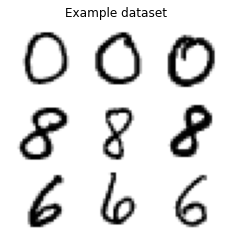

In [16]:
# @title Select subset from the dataset for training

labels_list = [0,8,6] #@param
num_samples_per_label = 3 #@param {type:'integer'}

raw_data = get_raw_data()
data = get_data_slice(raw_data, labels=(0, 8, 6), num_samples=num_samples_per_label)
imshow(gallery(data.image), title='Example dataset')

In [17]:
# @title Model and Optimisation selection
# @markdown Evaluate the performance and training of different models, by changing the prior-posterior combinations, and the optimisation type.


prior_posterior_model = "Gaussian + Gaussian" #@param ["Gaussian + Gaussian", "Uniform + Flow", "Truncated Gaussian + Flow"]
optimization_type = "Standard" #@param ["Standard", "Constrained"]
constraint_value = 0.1 #@param

if optimization_type == "Constrained":
  get_geco_loss = lambda d, t: get_geco_constraint(d, t, kappa=constraint_value)
  get_reconstruction_loss = get_geco_loss
elif optimization_type == "Standard":
  get_reconstruction_loss = get_log_likelihood
else:
  raise ValueError('Unsupported optimization type {}'.format(optimization_type))

if prior_posterior_model == "Uniform + Flow":
  init_model, step_model = get_model(
      get_prior_distribution=get_uniform_prior_distribution,
      get_posterior_distribution=get_flow_posterior_distribution,
      get_reconstruction_loss=get_reconstruction_loss)
  make_z_grid = lambda num_samples: get_z_grid(0, 1, num_samples); markersize = 1
  marker_size = 1
elif prior_posterior_model == "Gaussian + Gaussian":
  init_model, step_model = get_model(
      get_prior_distribution=get_normal_prior_distribution,
      get_posterior_distribution=get_normal_posterior_distribution,
      get_reconstruction_loss=get_reconstruction_loss)
  make_z_grid = lambda num_samples: get_z_grid(-2, 2, num_samples); markersize = 10
  marker_size = 10
elif prior_posterior_model == "Truncated Gaussian + Flow":
  init_model, step_model = get_model(
      get_prior_distribution=get_truncated_normal_prior_distribution,
      get_posterior_distribution=get_flow_posterior_distribution,
      get_reconstruction_loss=get_reconstruction_loss)
  make_z_grid = lambda num_samples: get_z_grid(-2, 2, num_samples); markersize = 10
  marker_size = 10
else:
  raise ValueError('Unsupported posterior model {}'.format(prior_posterior_model))



In [ ]:
# @title Initialise model and optimiser
key = jax.random.PRNGKey(3)
init_key, key = jax.random.split(key)

params = init_model(init_key, data.image)
opt_state = opt.init(params)

kls = []
mses = []
loss_data = []

In [ ]:
# @title Run training loop

# Run optimisation loop and visualise progress
# (re-run cell to continue training)
num_steps = 30000
start_time = time.time()
for _ in range(num_steps):
  params, opt_state, key, outputs = run(params, opt_state, key, data.image)
  kls.append(outputs['kl'])
  if 'lagmul' in outputs:
    loss_data.append(outputs['lagmul'])
  else:
    loss_data.append(outputs['loss'])  
  mses.append(outputs['MSE'])
training_time = time.time() - start_time

# Visusalise training progress
plot_figure(params, kls, mses, loss_data)
print(f"Total training time: {training_time:.2f}s, with final KL: {np.mean(kls[-int(0.1 * num_steps):]):.4f} and MSE: {np.mean(mses[-int(0.1 * num_steps):]):.4f}.")


---
## Tasks and Conclusions

In this part you will evaluate and analyse the latent space obtained using different prior-posterior pairs, as well as different losses (vanilla vs constrained optimisation).

Please follow the tasks defined below and answer the corresponding questions.

### **TASK 1** 
Use Gaussian prior + Gaussian posterior:
- Use only ELBO loss (Standard optimisation)
  - Observe the latent space and the value of KL and MSE
- Switch to GECO loss (Constrained optimisation) and add the desired MSE as `constraint_value` - copy the run loop cell for easier comparison
  - Observe the latent space and the value of KL and MSE


**Question 1.1:**
<br>
What difference do you observe between the two optimisation approaches in terms of the latent space coverage and achieved prior-posterior matching (KL term)? How does KL correlate with the spread of posterior samples within the latent space?


**Answer 1.1:**
<br>
By introducing the constrained optimisation, we can observe fewers holes within the latent space coverage. We can achieve a lower KL with the same MSE constraint, which means we match the prior more closely, and thus the latent space is covered better.

However, a large space of the latent space remains not covered, as fundamentally you can not cover the prior well and it is hard to tile the latent space because there is always some overlap.


**Question 1.2:**
<br>
What does the `lagrange_multiplier` plot tell us?

**Answer 1.2:**
<br>
The higher values in the plot correspond with a higher weight on the MSE term. Therefore, once the the lagrance multiplier drops to zero, the optimisation focuses on the KL term.

### **TASK 2**
Use Uniform prior + Flow posterior:

- Use only ELBO loss (Standard optimisation)
  - Observe the latent space and the value of KL and MSE, as well as training time
- Switch to GECO loss (Constrained optimisation) and add the desired MSE as `constraint_value` - copy the run loop cell for easier comparison
  - Observe the latent space and the value of KL and MSE, as well as training time


**Question 2.1:**
<br>
What difference do you observe between the two optimisation approaches in terms of the latent space coverage, achieved prior-posterior matching (KL term), and the overall time to convergence?


**Answer 2.1:**
<br>
ELBO: Very hard to optimise, even slower convergence than Gaussian. The latent space tiling is similar to that of Gaussian,
<br>
GECO: Training is much faster, latent space tiling is good as almost the whole space is tightly covered.


**Question 2.2:**
<br>
How does the Gaussian prior and posterior compare to using Uniform prior and Flow posterior in terms of training performance and latent space coverage, using GECO constrained optimisation approach?


**Answer 2.2:**
<br>
Although the training time is slightly longer, the latent space is densely covered. This is due to the flow distribution being a more powerful posterior, and a good match of prior and posterior.

### **TASK 3**
Use Truncated Gaussian prior + Flow posterior:

- Use only ELBO loss (Standard optimisation)
  - Observe the latent space and the value of KL and MSE, as well as training time
- Switch to GECO loss (Constrained optimisation) and add the desired MSE as `constraint_value` - copy the run loop cell for easier comparison
  - Observe the latent space and the value of KL and MSE, as well as training time


**Question 3.1:**
<br>
What difference do you observe between the two optimisation approaches in terms of the latent space coverage, achieved prior-posterior matching (KL term), and the overall time to convergence?


**Answer 3.1:**
<br>
It is similar to TASK 2.


**Question 3.2:**
<br>
How does the Truncated Gaussian prior and Flow posterior compare to using Uniform prior and Flow posterior, in terms of training performance and latent space coverage, using GECO constrained optimisation approach?


**Answer 3.2:**
<br>
The training time for both are similar, and the latent space is densely covered. This shows that the Truncated Gaussian distribution acts as a good prior as well.
<br>
However, the tile boundaries are not as clear as in the Uniform + Flow case, which we can see in the ||MSE|| plot.

### **TASK 4**

**Question 4:** 
<br>In the Flow implementation, what happens if we don't concatenate the context and the input:
<br>
`conditioned_input = jnp.concatenate([x, ctx], axis=-1)`?

**Answer 4:** 
<br>
The point is that the posterior is a distribution of the latent z, conditioned on the input image x. This is a way of passing the conditioning tensor to each layer of the flow.
If we do not pass this we lose the relation between latents and inputs.